## 2.1 Loading the MNIST dataset
    The MNIST dataset consists of seventy thousand labelled images, each depicting a single handwritten digit. This may sound like a lot of data, but as you’ll see for yourselves in a bit, the images are rather small.
    The MNIST dataset is included in TensorFlow, so you getting access to it is actually pretty easy. You can load it directly into your code like this:

In [31]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train','test'], 
                                        as_supervised=True, with_info=True)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\п\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

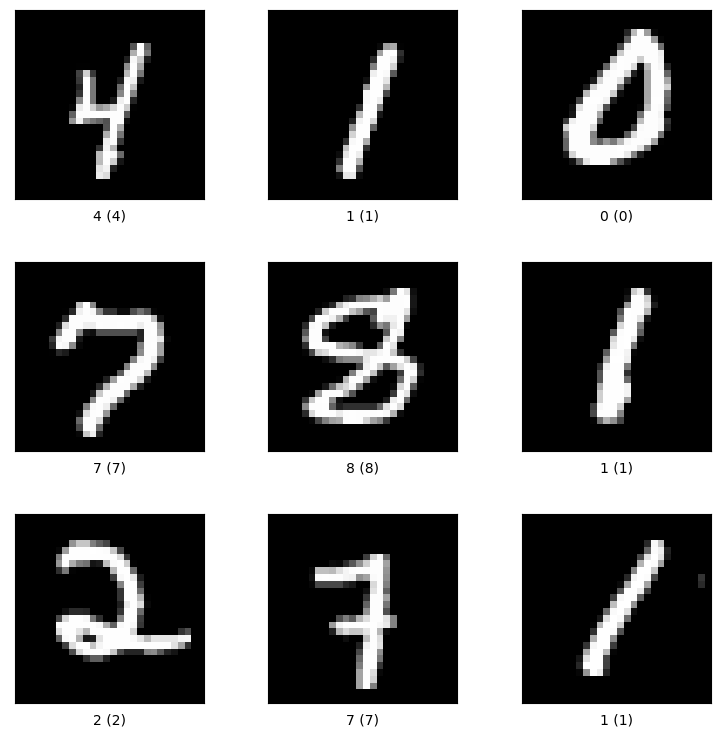

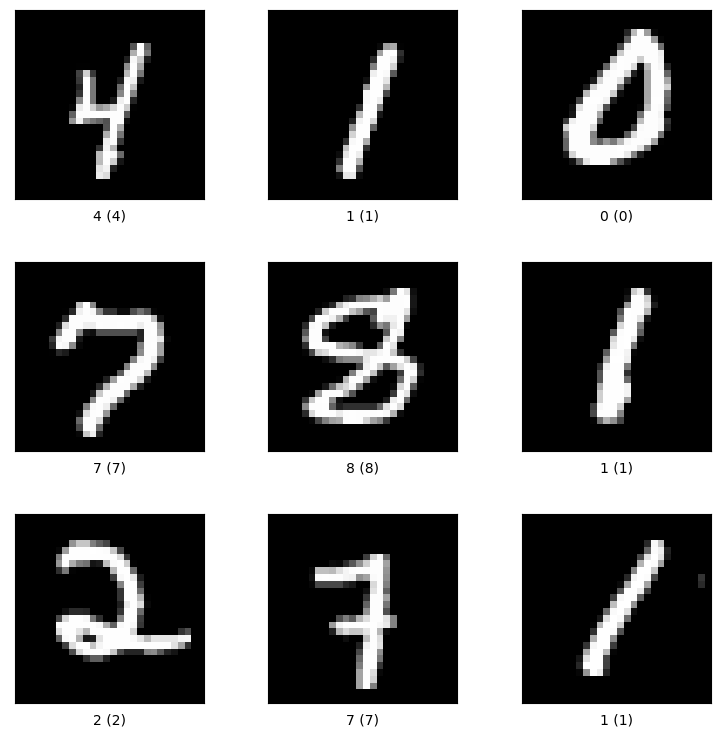

In [32]:
# Show the information about MNIST dataset
print(ds_info)
tfds.show_examples(train_ds, ds_info)

    When working with data, always make sure that you understand what you are dealing with first! How many entries are there in the dataset? What is the format? You must consider questions like these every time you are designing a network. 
Answer the following:
    • How many training/test images are there?
    • What’s the image shape?
    • What range are pixel values in?

Training images = 60000
Test images = 10000
Image shape:
    height = 28
    width = 20
    color depth = 1

Pixels are unsigned 8-it integer numbers in rabge from 0 to 255

## 2.2 Setting up the data pipeline
    After getting to know the dataset it makes sense to create a data pipeline function that prepares your data for use in your  model. You can use this pipeline to prepare the training and test data one after another for use in your network. You can obtain the dataset from the tensorflow-datasets package as showcased in the lecture1. In your pipeline you will need to do a number of things. You may follow the example code from the lecture again closely here, but let’s summarize the steps:
    The MNIST handwritten digits images come in uint8 datatype. This refers to unsigned 8-bit integers (think numbers 0-255). As the network requires float values (think continuous variables) as input rather than integers (whole numbers), we need to change the datatype: (map2 in combination with lambda expressions3 can be really useful here). In your first lambda mapping you want to change the datatype from uint8 to tf.float values 4. To feed your network the 28x28 images also need to be flattened. Check out the reshape function 5, and if you want to minimize your work, try and understand how it interacts with size elements set to the value -1 (infering the remainder shape). In order to improve the performance you should also normalize your image values. Generally this means bringing the input close to the standart normal (gaussian) distribution with µ = 0 and σ = 1, however we can make a quick approximation as that: Knowing the inputs are in the 0-255 interval, we can simply divide all numbers by 128 (bringing them between 0-2), and finally subtracting one (bringing them into -1 to 1 range). Additionally you need to encode your labels as one-hotvectors6. Remember a very similar example for the data preparation can be found in the lecture contents.

In [33]:
# Create a data pipeline function that prepares data for use in the model
def prepare_mnist_data(mnist):
    # flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # Convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    # Create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    # Shuffle data
    mnist = mnist.shuffle(1000)
    # Batch data
    mnist = mnist.batch(32)
    # Prefetch data
    mnist = mnist.prefetch(20)
    # Return preprocessed dataset
    return mnist

## 2.3 Building a deep neural network with TensorFlow
    Now that you have your data pipeline built, it is time to create your network. Check out the courseware for how to go about building a network with TensorFlow’s Keras. Following that method, we want you to build a fully connected feed-forward neural network to classify MNIST images with. To do this, have a look at ’Dense’ layers7; they basically provide you with the same functionality as the ’Layer’ class which you have implemented last week. TensorFlow also provides you with every activation function you might need for this course8. A good (albeit arbitrary) starting point would be to have two hidden layers with 256 units each. For your output layer, think about how many units you need,and consider which activation function is most appropriate for this task.

In [34]:
# Create feed-froward neural network class
class NNModel(tf.keras.Model):
    def __init__(self):
        super(NNModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)

        return x

## 2.4 Training the network
Define a training loop function which receives
    • The number of epochs
    • The model object
    • The training dataset
    • The test dataset
    • The loss function
    • The optimizer
    • Different arrays for the different values you want to track for visualization
It should return the filled arrays after your model is done training. Before you call the function you will have to define your hyperparameters and initialize everything. To start off you can use 10 epochs, a learning rate of 0.1, the categorical cross entropy loss9 and the optimizer SGD10.

In [35]:
# Train neural network
def train_step(model, input, target, loss_function, optimizer):
    # Loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

tf.keras.backend.clear_session()

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

# For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = NNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

# Testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    # Track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1228125
Epoch: 1 starting with accuracy 0.81
Epoch: 2 starting with accuracy 0.8603125
Epoch: 3 starting with accuracy 0.8825
Epoch: 4 starting with accuracy 0.8925
Epoch: 5 starting with accuracy 0.8928125
Epoch: 6 starting with accuracy 0.9025
Epoch: 7 starting with accuracy 0.9025
Epoch: 8 starting with accuracy 0.90625
Epoch: 9 starting with accuracy 0.9040625


## 2.5 Visualization
    After traing visualize the performance of your model using matplotlib and the values that you collected during training and testing. Here is just one example that you could use.

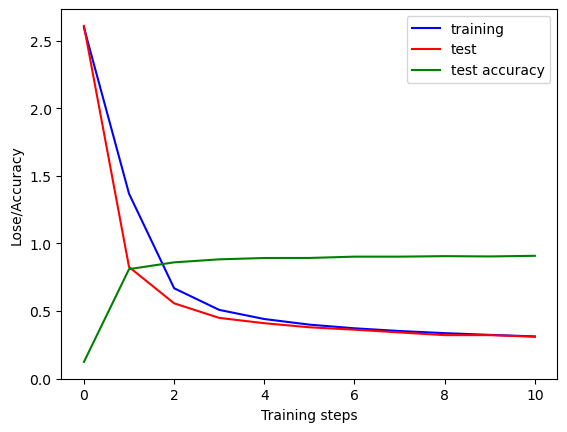

In [36]:
def visualization (train_losses, test_losses, test_accuracies):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch . 
    Loss is displayed in a regular line , accuracy in a dotted
    line . 
    Training data is displayed in blue , test data in red . 
    Parameters
    ----------
    train_losses : numpy . ndarray
      training losses
    train_accuracies : numpy . ndarray
      training accuracies
    test_losses : numpy . ndarray
      test losses
    test_accuracies : numpy . ndarray
      test accuracies
    """

    plt.figure()
    line1, = plt.plot(train_losses, 'b-')
    line2, = plt.plot(test_losses, 'r-')
    line3, = plt.plot(test_accuracies, 'g-')
    plt.xlabel('Training steps')
    plt.ylabel('Lose/Accuracy')
    plt.legend((line1,line2,line3), ('training','test','test accuracy'))

    plt.show()
    
visualization(train_losses, test_losses, test_accuracies)

## 3 Adjusting the hyperparameters of your model
Attempt 1
Changing batch size from 32 to 16
Changing number of epochs from 10 to 25
Changing learing rate from 0.001 to 0.1

Attempt 2
Changing batch size from 32 to 16
Number of epochs remains 10
Learning rate remains 0.001

Attempt 3
Changing number of epochs from 10 to 25
Batch size remains 32
Learning rate remains 0.001

Attempt 4
Changing learning rate from 0.001 to 0.1
Batch size remains 32
Number of epochs remains 10

In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train','test'], 
                                        as_supervised=True, with_info=True)

In [11]:
# Create a data pipeline function that prepares data for use in the model
# Test 1, 2
def prepare_mnist_data_12(mnist):
    # flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # Convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    # Create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    # Shuffle data
    mnist = mnist.shuffle(1000)
    # Batch data
    mnist = mnist.batch(16)
    # Prefetch data
    mnist = mnist.prefetch(20)
    # Return preprocessed dataset
    return mnist

train_dataset_12 = train_ds.apply(prepare_mnist_data_12)
test_dataset_12 = test_ds.apply(prepare_mnist_data_12)

In [12]:
# Test 3, 4
def prepare_minst_data_34(mnist):
# flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # Convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    # Create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    # Shuffle data
    mnist = mnist.shuffle(1000)
    # Batch data
    mnist = mnist.batch(32)
    # Prefetch data
    mnist = mnist.prefetch(20)
    # Return preprocessed dataset
    return mnist

train_dataset_34 = train_ds.apply(prepare_minst_data_34)
test_dataset_34 = train_ds.apply(prepare_minst_data_34)

In [13]:
# Create feed-froward neural network class
class NNModel(tf.keras.Model):
    def __init__(self):
        super(NNModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)

        return x

In [14]:
# Train neural network
def train_step(model, input, target, loss_function, optimizer):
    # Loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [15]:
tf.keras.backend.clear_session()

# For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset_12 = train_dataset_12.take(1000)
test_dataset_12 = test_dataset_12.take(100)
train_dataset_34 = train_dataset_34.take(1000)
test_dataset_34 = test_dataset_34.take(100)

In [16]:
### Hyperparameters. 
# Number of epochs = 25 on test 1 and 3
# Number of epochs = 10 on test 2 and 4
num_epochs_13 = 25
num_epochs_24 = 10

### Hyperparameters.
# Learning rate = 0.3 on test 1 and 4
# Learning rate = 0.001 on test 2 and 3
learning_rate_14 = 0.1
learning_rate_23 = 0.001

In [17]:
# Initialize lists for later visualization.
train_losses_1 = []
train_losses_2 = []
train_losses_3 = []
train_losses_4 = []
    
test_losses_1 = []
test_losses_2 = []
test_losses_3 = []
test_losses_4 = []
    
test_accuracies_1 = []
test_accuracies_2 = []
test_accuracies_3 = []
test_accuracies_4 = []

In [18]:
# Test 1
# Initialize the model.
model = NNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer_14 = tf.keras.optimizers.SGD(learning_rate_14)

# Testing once before we begin
test_loss_1, test_accuracy_1 = test(model, test_dataset_12, cross_entropy_loss)
test_losses_1.append(test_loss_1)
test_accuracies_1.append(test_accuracy_1)

#check how model performs on train data once before we begin
train_loss_1, _ = test(model, train_dataset_12, cross_entropy_loss)
train_losses_1.append(train_loss_1)

# We train for num_epochs epochs
for epoch_1 in range(num_epochs_13):
    print(f'Epoch: {str(epoch_1)} starting with accuracy {test_accuracies_1[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg_1 = []
    for input, target in train_dataset_12:
        train_loss_1 = train_step(model, input, target, cross_entropy_loss, optimizer_14)
        epoch_loss_agg_1.append(train_loss_1)
    
    # Track training loss
    train_losses_1.append(tf.reduce_mean(epoch_loss_agg_1))

    #testing, so we can track accuracy and test loss
    test_loss_1, test_accuracy_1 = test(model, test_dataset_12, cross_entropy_loss)
    test_losses_1.append(test_loss_1)
    test_accuracies_1.append(test_accuracy_1)

Epoch: 0 starting with accuracy 0.1175
Epoch: 1 starting with accuracy 0.931875
Epoch: 2 starting with accuracy 0.91875
Epoch: 3 starting with accuracy 0.9325
Epoch: 4 starting with accuracy 0.938125
Epoch: 5 starting with accuracy 0.94625
Epoch: 6 starting with accuracy 0.943125
Epoch: 7 starting with accuracy 0.961875
Epoch: 8 starting with accuracy 0.9525
Epoch: 9 starting with accuracy 0.9525
Epoch: 10 starting with accuracy 0.95625
Epoch: 11 starting with accuracy 0.95625
Epoch: 12 starting with accuracy 0.908125
Epoch: 13 starting with accuracy 0.9275
Epoch: 14 starting with accuracy 0.93875
Epoch: 15 starting with accuracy 0.951875
Epoch: 16 starting with accuracy 0.9475
Epoch: 17 starting with accuracy 0.951875
Epoch: 18 starting with accuracy 0.97125
Epoch: 19 starting with accuracy 0.950625
Epoch: 20 starting with accuracy 0.96125
Epoch: 21 starting with accuracy 0.936875
Epoch: 22 starting with accuracy 0.9525
Epoch: 23 starting with accuracy 0.928125
Epoch: 24 starting with

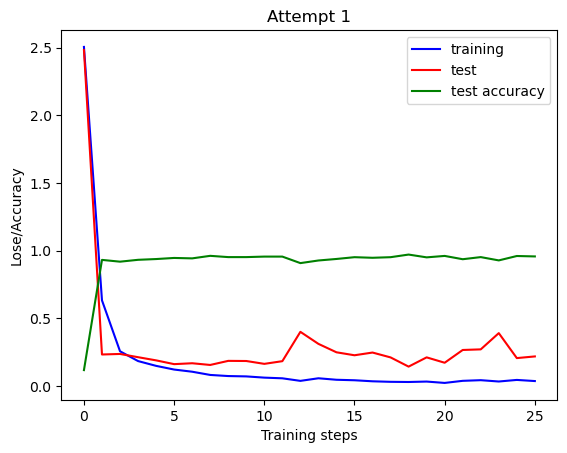

In [44]:
# Test 1
def visualization_1 (train_losses, test_losses, test_accuracies, attempt_number):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch . 
    Loss is displayed in a regular line , accuracy in a dotted
    line . 
    Training data is displayed in blue , test data in red . 
    Parameters
    ----------
    train_losses : numpy . ndarray
      training losses
    train_accuracies : numpy . ndarray
      training accuracies
    test_losses : numpy . ndarray
      test losses
    test_accuracies : numpy . ndarray
      test accuracies
    """

    plt.figure()
    line11, = plt.plot(train_losses, 'b-')
    line12, = plt.plot(test_losses, 'r-')
    line13, = plt.plot(test_accuracies, 'g-')
    plt.xlabel('Training steps')
    plt.ylabel('Lose/Accuracy')
    plt.legend((line11,line12,line13), ('training','test','test accuracy'))
    plt.title(f'Attempt {attempt_number}')

    plt.show()

visualization_1(train_losses_1, test_losses_1, test_accuracies_1, 1)

In [20]:
# Test 2
# Initialize the model.
model = NNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer_23 = tf.keras.optimizers.SGD(learning_rate_23)

# Testing once before we begin
test_loss_2, test_accuracy_2 = test(model, test_dataset_12, cross_entropy_loss)
test_losses_2.append(test_loss_2)
test_accuracies_2.append(test_accuracy_2)

#check how model performs on train data once before we begin
train_loss_2, _ = test(model, train_dataset_12, cross_entropy_loss)
train_losses_2.append(train_loss_2)

# We train for num_epochs epochs
for epoch_2 in range(num_epochs_24):
    print(f'Epoch: {str(epoch_2)} starting with accuracy {test_accuracies_2[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg_2 = []
    for input, target in train_dataset_12:
        train_loss_2 = train_step(model, input, target, cross_entropy_loss, optimizer_23)
        epoch_loss_agg_2.append(train_loss_2)
    
    # Track training loss
    train_losses_2.append(tf.reduce_mean(epoch_loss_agg_2))

    #testing, so we can track accuracy and test loss
    test_loss_2, test_accuracy_2 = test(model, test_dataset_12, cross_entropy_loss)
    test_losses_2.append(test_loss_2)
    test_accuracies_2.append(test_accuracy_2)


Epoch: 0 starting with accuracy 0.145
Epoch: 1 starting with accuracy 0.82125
Epoch: 2 starting with accuracy 0.864375
Epoch: 3 starting with accuracy 0.88625
Epoch: 4 starting with accuracy 0.903125
Epoch: 5 starting with accuracy 0.89875
Epoch: 6 starting with accuracy 0.890625
Epoch: 7 starting with accuracy 0.906875
Epoch: 8 starting with accuracy 0.91125
Epoch: 9 starting with accuracy 0.910625


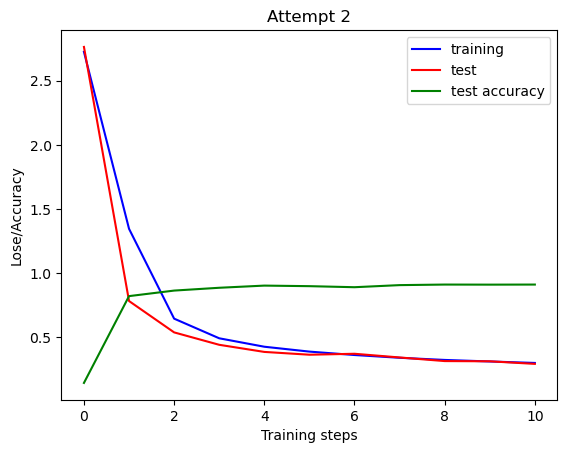

In [45]:
# Test 2
def visualization_2 (train_losses, test_losses, test_accuracies, attempt_number):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch . 
    Loss is displayed in a regular line , accuracy in a dotted
    line . 
    Training data is displayed in blue , test data in red . 
    Parameters
    ----------
    train_losses : numpy . ndarray
      training losses
    train_accuracies : numpy . ndarray
      training accuracies
    test_losses : numpy . ndarray
      test losses
    test_accuracies : numpy . ndarray
      test accuracies
    """

    plt.figure()
    line21, = plt.plot(train_losses, 'b-')
    line22, = plt.plot(test_losses, 'r-')
    line23, = plt.plot(test_accuracies, 'g-')
    plt.xlabel('Training steps')
    plt.ylabel('Lose/Accuracy')
    plt.legend((line21,line22,line23), ('training','test','test accuracy'))
    plt.title(f'Attempt {attempt_number}')

    plt.show()

visualization_2(train_losses_2, test_losses_2, test_accuracies_2, 2)

In [22]:
# Test 3
# Initialize the model.
model = NNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer_23 = tf.keras.optimizers.SGD(learning_rate_23)
# Testing once before we begin
test_loss_3, test_accuracy_3 = test(model, test_dataset_34, cross_entropy_loss)
test_losses_3.append(test_loss_3)
test_accuracies_3.append(test_accuracy_3)

#check how model performs on train data once before we begin
train_loss_3, _ = test(model, train_dataset_34, cross_entropy_loss)
train_losses_3.append(train_loss_3)

# We train for num_epochs epochs
for epoch_3 in range(num_epochs_13):
    print(f'Epoch: {str(epoch_3)} starting with accuracy {test_accuracies_3[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg_3 = []
    for input, target in train_dataset_34:
        train_loss_3 = train_step(model, input, target, cross_entropy_loss, optimizer_23)
        epoch_loss_agg_3.append(train_loss_3)
    
    # Track training loss
    train_losses_3.append(tf.reduce_mean(epoch_loss_agg_3))

    #testing, so we can track accuracy and test loss
    test_loss_3, test_accuracy_3 = test(model, test_dataset_34, cross_entropy_loss)
    test_losses_3.append(test_loss_3)
    test_accuracies_3.append(test_accuracy_3)

Epoch: 0 starting with accuracy 0.1371875
Epoch: 1 starting with accuracy 0.800625
Epoch: 2 starting with accuracy 0.8478125
Epoch: 3 starting with accuracy 0.8725
Epoch: 4 starting with accuracy 0.8865625
Epoch: 5 starting with accuracy 0.895
Epoch: 6 starting with accuracy 0.895625
Epoch: 7 starting with accuracy 0.9025
Epoch: 8 starting with accuracy 0.9028125
Epoch: 9 starting with accuracy 0.9090625
Epoch: 10 starting with accuracy 0.91125
Epoch: 11 starting with accuracy 0.9165625
Epoch: 12 starting with accuracy 0.9184375
Epoch: 13 starting with accuracy 0.9121875
Epoch: 14 starting with accuracy 0.9165625
Epoch: 15 starting with accuracy 0.92
Epoch: 16 starting with accuracy 0.9253125
Epoch: 17 starting with accuracy 0.9240625
Epoch: 18 starting with accuracy 0.9296875
Epoch: 19 starting with accuracy 0.925625
Epoch: 20 starting with accuracy 0.9309375
Epoch: 21 starting with accuracy 0.926875
Epoch: 22 starting with accuracy 0.9321875
Epoch: 23 starting with accuracy 0.933125


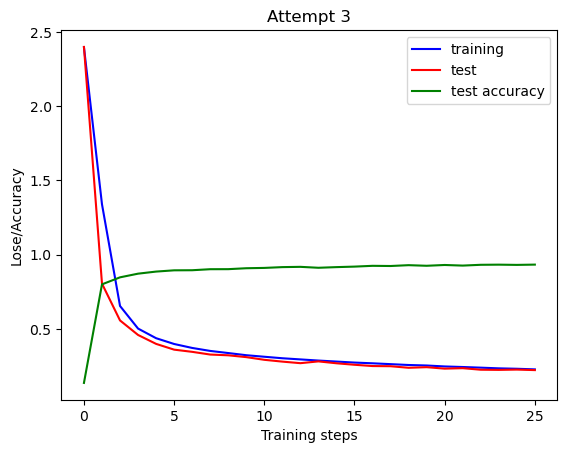

In [46]:
# Test 3
def visualization_3 (train_losses, test_losses, test_accuracies, attempt_number):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch . 
    Loss is displayed in a regular line , accuracy in a dotted
    line . 
    Training data is displayed in blue , test data in red . 
    Parameters
    ----------
    train_losses : numpy . ndarray
      training losses
    train_accuracies : numpy . ndarray
      training accuracies
    test_losses : numpy . ndarray
      test losses
    test_accuracies : numpy . ndarray
      test accuracies
    """

    plt.figure()
    line31, = plt.plot(train_losses, 'b-')
    line32, = plt.plot(test_losses, 'r-')
    line33, = plt.plot(test_accuracies, 'g-')
    plt.xlabel('Training steps')
    plt.ylabel('Lose/Accuracy')
    plt.legend((line31,line32,line33), ('training','test','test accuracy'))
    plt.title(f'Attempt {attempt_number}')

    plt.show()

visualization_3(train_losses_3, test_losses_3, test_accuracies_3, 3)

In [24]:
# Test 4
# Initialize the model.
model = NNModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer_14 = tf.keras.optimizers.SGD(learning_rate_14)

# Testing once before we begin
test_loss_4, test_accuracy_4 = test(model, test_dataset_34, cross_entropy_loss)
test_losses_4.append(test_loss_4)
test_accuracies_4.append(test_accuracy_4)

#check how model performs on train data once before we begin
train_loss_4, _ = test(model, train_dataset_34, cross_entropy_loss)
train_losses_4.append(train_loss_4)

# We train for num_epochs epochs
for epoch_4 in range(num_epochs_24):
    print(f'Epoch: {str(epoch_4)} starting with accuracy {test_accuracies_4[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg_4 = []
    for input, target in train_dataset_34:
        train_loss_4 = train_step(model, input, target, cross_entropy_loss, optimizer_14)
        epoch_loss_agg_4.append(train_loss_4)
    
    # Track training loss
    train_losses_4.append(tf.reduce_mean(epoch_loss_agg_4))

    #testing, so we can track accuracy and test loss
    test_loss_4, test_accuracy_4 = test(model, test_dataset_34, cross_entropy_loss)
    test_losses_4.append(test_loss_4)
    test_accuracies_4.append(test_accuracy_4)

Epoch: 0 starting with accuracy 0.106875
Epoch: 1 starting with accuracy 0.9034375
Epoch: 2 starting with accuracy 0.9421875
Epoch: 3 starting with accuracy 0.9584375
Epoch: 4 starting with accuracy 0.965
Epoch: 5 starting with accuracy 0.975625
Epoch: 6 starting with accuracy 0.96625
Epoch: 7 starting with accuracy 0.9865625
Epoch: 8 starting with accuracy 0.990625
Epoch: 9 starting with accuracy 0.981875


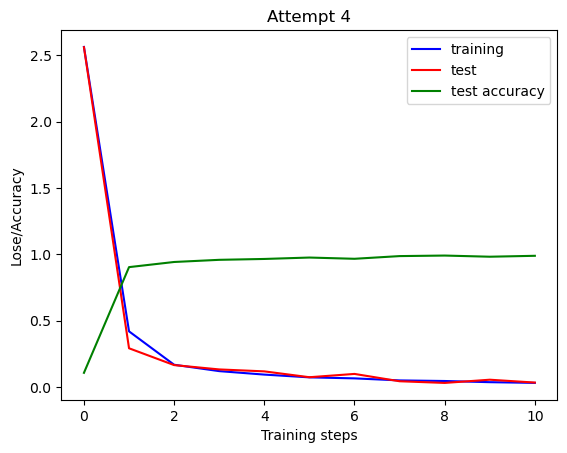

In [47]:
# Test 4
def visualization_4 (train_losses, test_losses, test_accuracies, attempt_number):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch . 
    Loss is displayed in a regular line , accuracy in a dotted
    line . 
    Training data is displayed in blue , test data in red . 
    Parameters
    ----------
    train_losses : numpy . ndarray
      training losses
    train_accuracies : numpy . ndarray
      training accuracies
    test_losses : numpy . ndarray
      test losses
    test_accuracies : numpy . ndarray
      test accuracies
    """

    plt.figure()
    line41, = plt.plot(train_losses, 'b-')
    line42, = plt.plot(test_losses, 'r-')
    line43, = plt.plot(test_accuracies, 'g-')
    plt.xlabel('Training steps')
    plt.ylabel('Lose/Accuracy')
    plt.legend((line41,line42,line43), ('training','test','test accuracy'))
    plt.title(f'Attempt {attempt_number}')

    plt.show()

visualization_4(train_losses_4, test_losses_4, test_accuracies_4, 4)

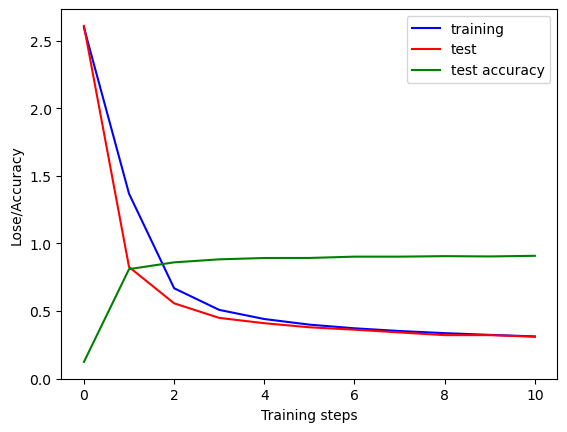

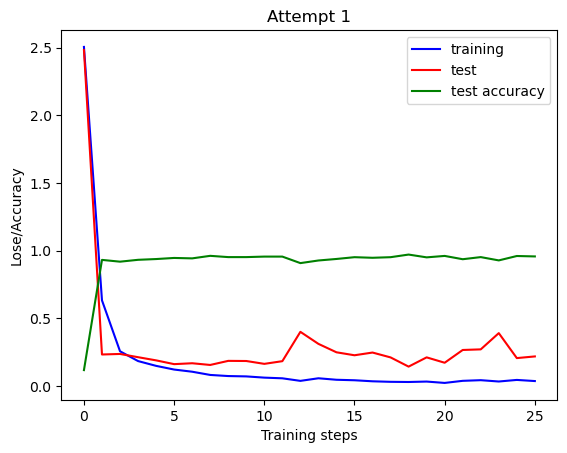

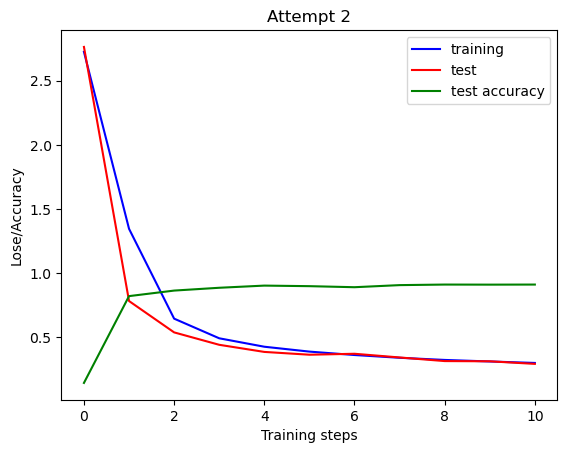

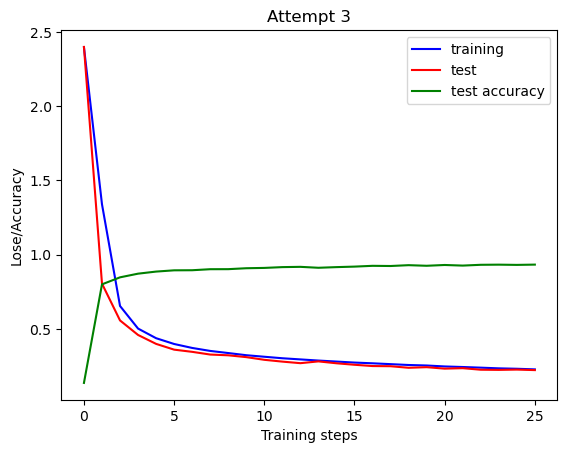

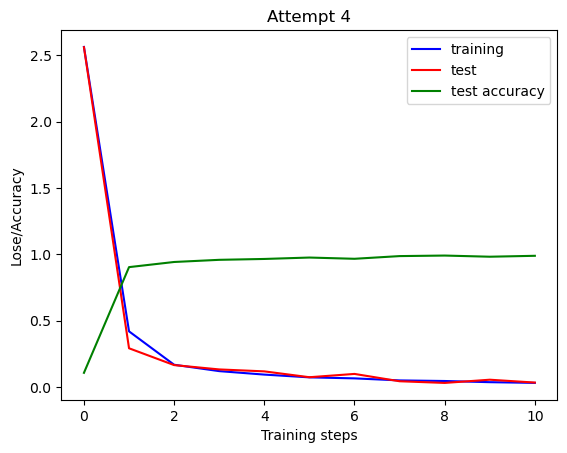

In [48]:
# Original Attempt visualization
visualization(train_losses, test_losses, test_accuracies)
# Attempt1 visualization
visualization_1(train_losses_1, test_losses_1, test_accuracies_1, 1)
# Attempt2 visualization
visualization_2(train_losses_2, test_losses_2, test_accuracies_2, 2)
# Attempt3 visualization
visualization_3(train_losses_3, test_losses_3, test_accuracies_3, 3)
# Attempt4 visualization
visualization_4(train_losses_4, test_losses_4, test_accuracies_4, 4)

## Conclusions
We compared original training model with each testing model.
Attempt 1: Changing all parameters(batch size,number of epochs,learning rate) decreases train loss and test loss and a litte increase the test accuracy.
Attempt 2: Number of epochs and learning rate remains the same. Changing batch size remains all parameters(batch size,number of epochs,learning rate) almost the same at the end.
Attempt 3: Batch size and learning rate remains the same. Changing number of epochs a litte increases the test accuracy and a litte decreases the train loss in the beginning. All parameters(batch size,number of epochs,learning rate) almost the same at the end.
Attempt 4: Number of epochs and batch size remains the same. Changing learning rate decreases the training loss and test loss. The learing rate remains the same.